In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import DataFrame, read_csv, read_excel, concat, get_dummies, isna
from re import split, search, sub
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import statsmodels.api as sm

In [9]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_anova_df=''
)
anova_df = data_frames_dict['metrics_evaluation_open_world_anova_df'].copy()
print(anova_df.shape)

No pickle exists for metrics_evaluation_open_world_anova_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_anova_df.csv.
(68, 167)


In [10]:

anova_df = anova_df.rename(columns={cn: cn[5:] for cn in anova_df.columns if cn.startswith('mean_')})

#  Analysis of KDMA Values in Triage Decisions

In [12]:

print("Get column and value descriptions")
file_path = osp.join(nu.data_folder, 'xlsx', 'Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx')
dataset_organization_df = read_excel(file_path)

print("Fix the doubled up descriptions")
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Get a copy of the row
    new_row = dataset_organization_df.loc[row_index].copy()
    
    # Modify the desired column value
    new_row['Labels'] = labels_list[1]
    
    # Append the new row to the DataFrame
    dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

# Get a copy of the row
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()

# Modify the desired column value
new_row['Variable'] = 'AD_Del_Omni_Text'

# Append the new row to the DataFrame
dataset_organization_df = concat([dataset_organization_df, new_row], ignore_index=True)

print("Get the column value descriptions")
mask_series = ~dataset_organization_df.Description.isnull()
df = dataset_organization_df[mask_series]
value_description_dict = df.set_index('Variable').Description.to_dict()
new_description_dict = value_description_dict.copy()
for k, v in value_description_dict.items():
    new_description_dict[k] = v
    if (not k.endswith('_Text')):
        new_key_name = f'{k}_Text'
        new_description_dict[new_key_name] = new_description_dict.get(new_key_name, v)
value_description_dict = new_description_dict.copy()

Get column and value descriptions
Fix the doubled up descriptions
Get the column value descriptions


In [25]:

print("Create the value description function")
numeric_categories_mask_series = dataset_organization_df.Labels.map(lambda x: '=' in str(x))
value_descriptions_columns = dataset_organization_df[numeric_categories_mask_series].Variable.unique().tolist()
def get_value_description(column_name, column_value):
    value_description = ''
    if not isna(column_value):
        mask_series = (dataset_organization_df.Variable == column_name) & ~dataset_organization_df.Labels.isnull()
        if mask_series.any():
            df = dataset_organization_df[mask_series]
            mask_series = df.Labels.map(lambda label: split(' *= *', str(label), 0)[0] == str(int(float(column_value))))
            if mask_series.any():
                label = df[mask_series].Labels.squeeze()
                value_description = split(' *= *', str(label), 0)[1]
    
    return value_description

Create the value description function



## KDMAs and Prioritizing Still Patients in VR Triage Simulation (Question 1)

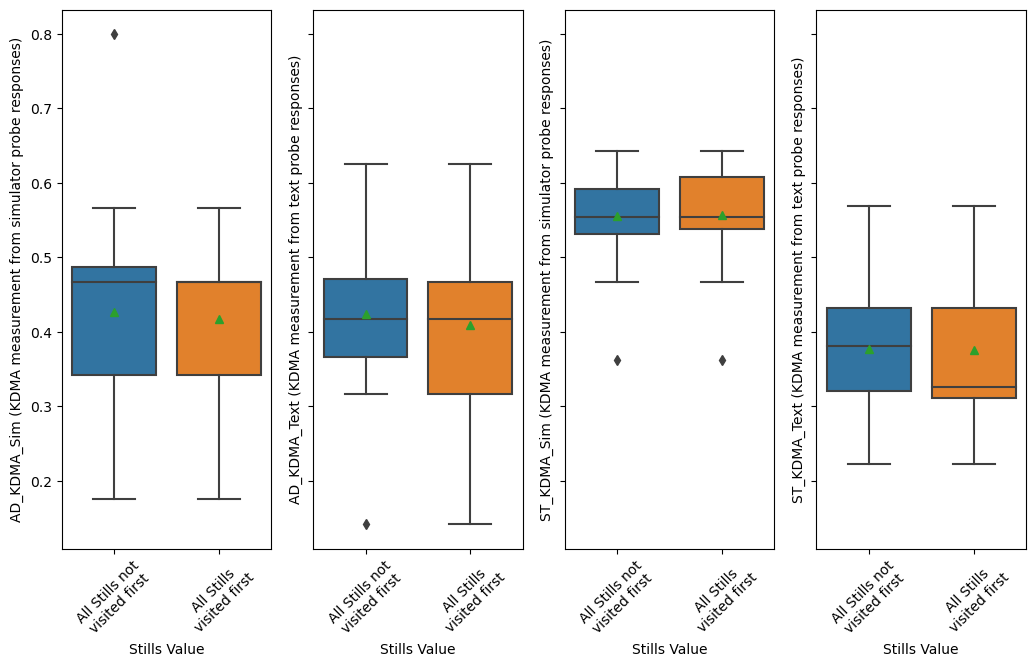

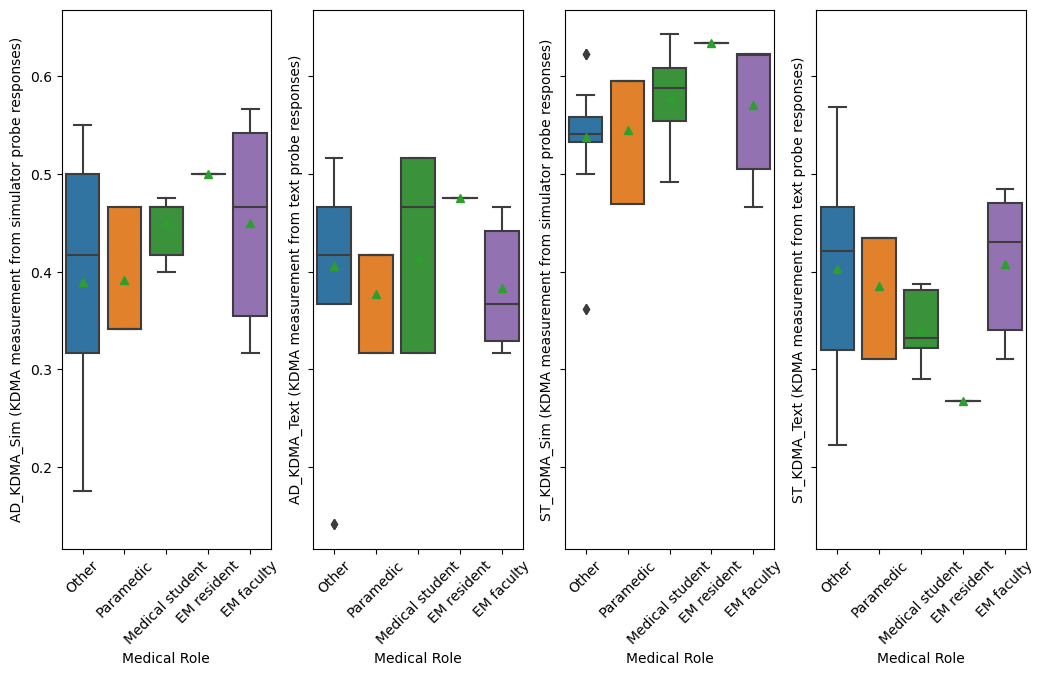

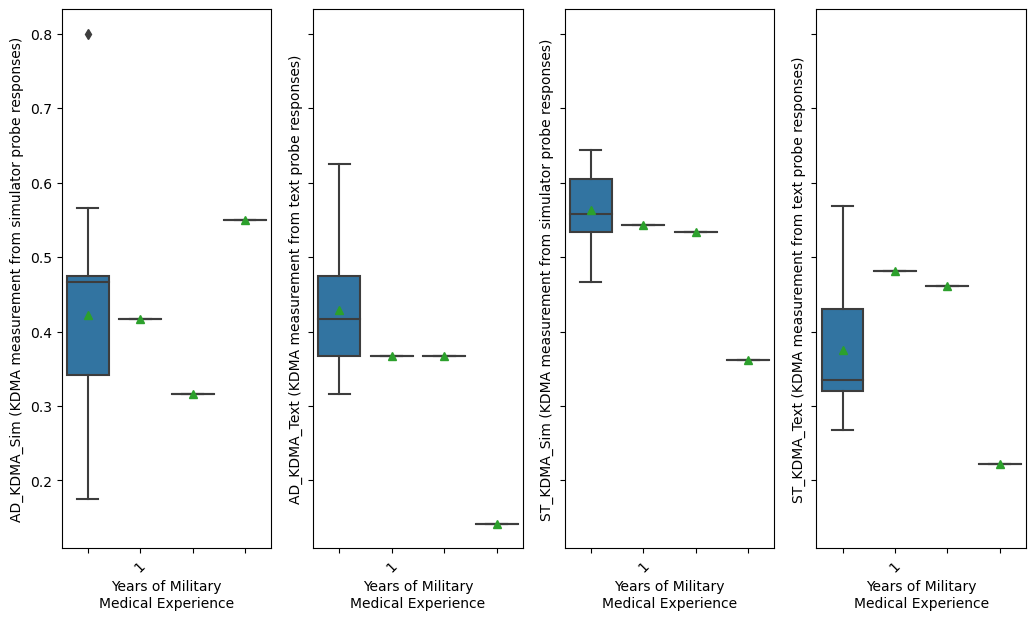

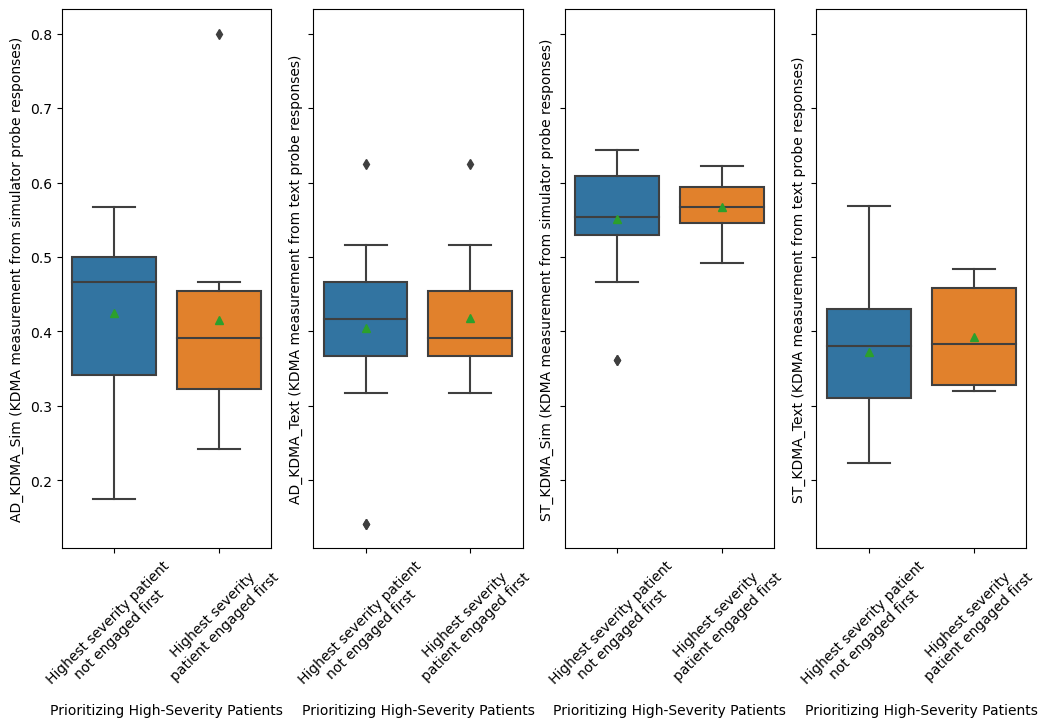

In [34]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

kdma_columns = [cn for cn in anova_df.columns if 'KDMA' in cn]
fig_height = 7
for xname, xlabel in zip(
    ['stills_value', 'medical_role', 'YrsMilExp', 'prioritize_high_injury_severity_patients'],
    ['Stills Value', 'Medical Role', 'Years of Military\nMedical Experience', 'Prioritizing High-Severity Patients']
):
    if xname == 'stills_value':
        labels_dict = {0: 'All Stills not\nvisited first', 1: 'All Stills\nvisited first'}
    elif xname == 'medical_role':
        labels_dict = {0: 'Other', 1: 'Paramedic', 2: 'Medical student', 3: 'EM resident', 4: 'EM faculty'}
    elif xname == 'prioritize_high_injury_severity_patients':
        labels_dict = {0: 'Highest severity patient\nnot engaged first', 1: 'Highest severity\npatient engaged first'}
    else:
        labels_dict = {column_value: get_value_description(xname, column_value) for column_value in anova_df[xname].unique()}
    
    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(kdma_columns), figsize=(nu.twitter_aspect_ratio*fig_height, fig_height), sharey=True)
    
    for i, cn in enumerate(kdma_columns):
        
        # Create a box plot of the y column grouped by the x column
        sns.boxplot(
            x = xname,
            y = cn,
            showmeans=True,
            data=anova_df,
            ax=axes[i]
        )
        
        # Label the x- and y-axis
        axes[i].set_xlabel(xlabel)
        original_column = cn.replace('mean_', '')
        column_description = value_description_dict[original_column]
        axes[i].set_ylabel(f'{original_column} ({column_description})')
        
        # Replace the x tick labels with text
        xticklabels_list = []
        for text_obj in axes[i].get_xticklabels():
            text_obj.set_text(labels_dict.get(text_obj.get_position()[0], text_obj.get_position()[0]))
            xticklabels_list.append(text_obj)
        axes[i].set_xticklabels(xticklabels_list)
        
        # Rotate xtick labels for each subplot (minor adjustment)
        axes[i].set_xticks(axes[i].get_xticks())  # Get current xticks
        plt.setp(axes[i].get_xticklabels(), rotation=45)  # Rotate labels for current axis
    
    plt.show()

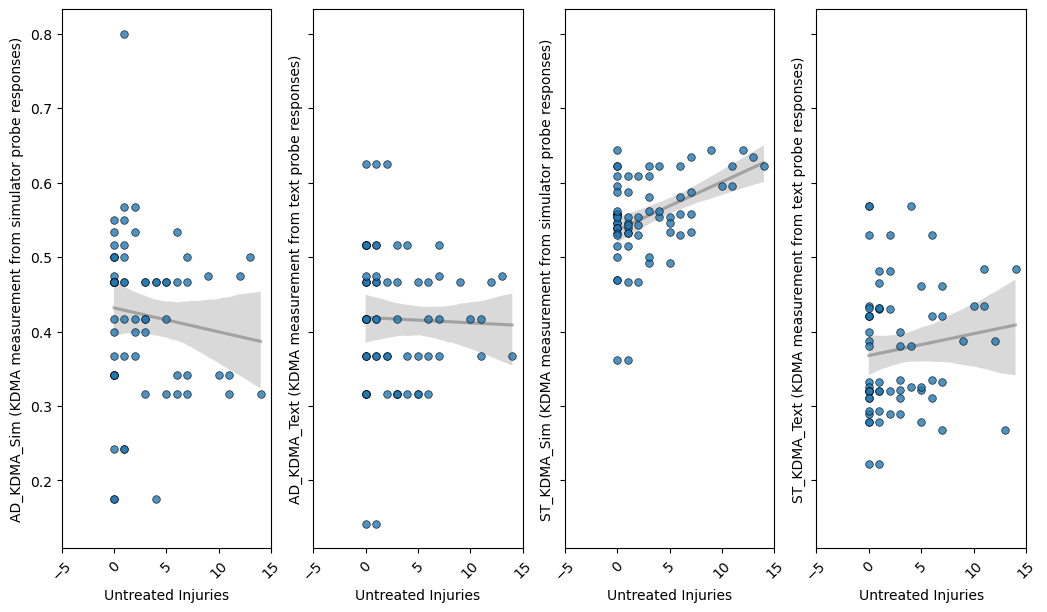

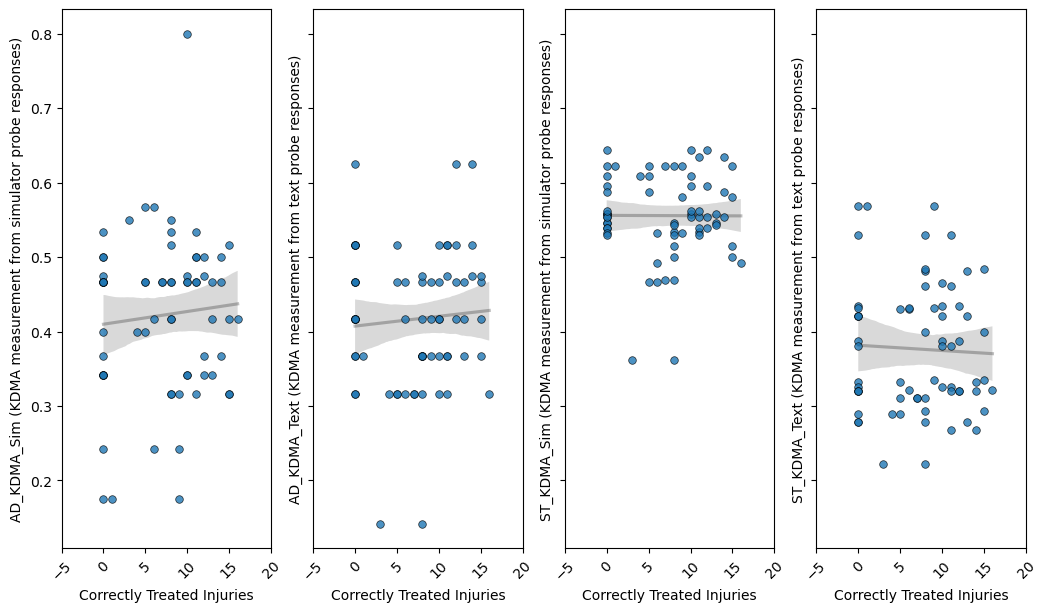

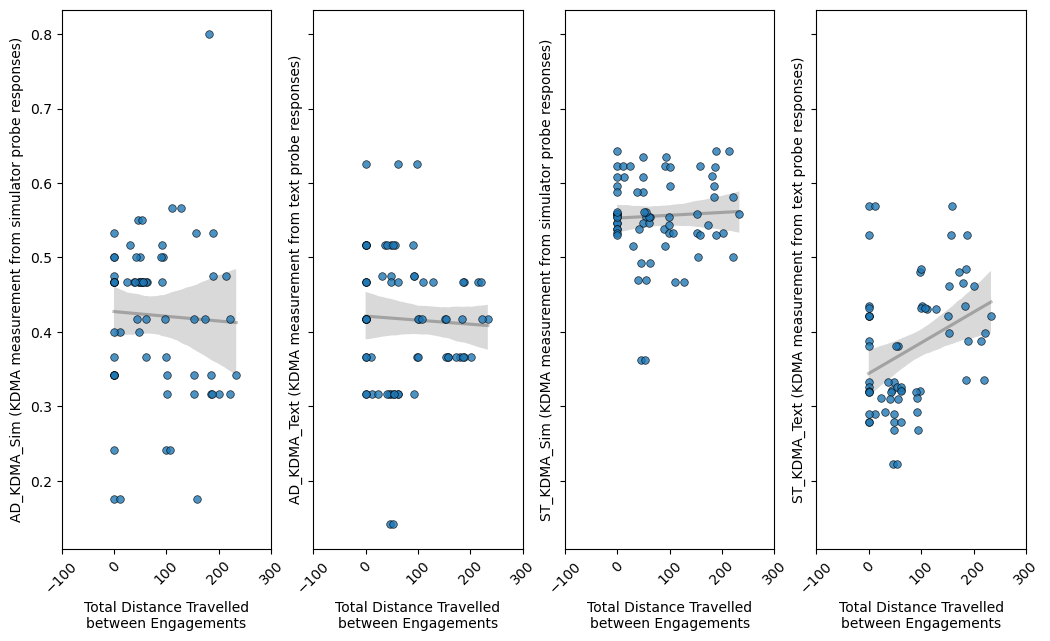

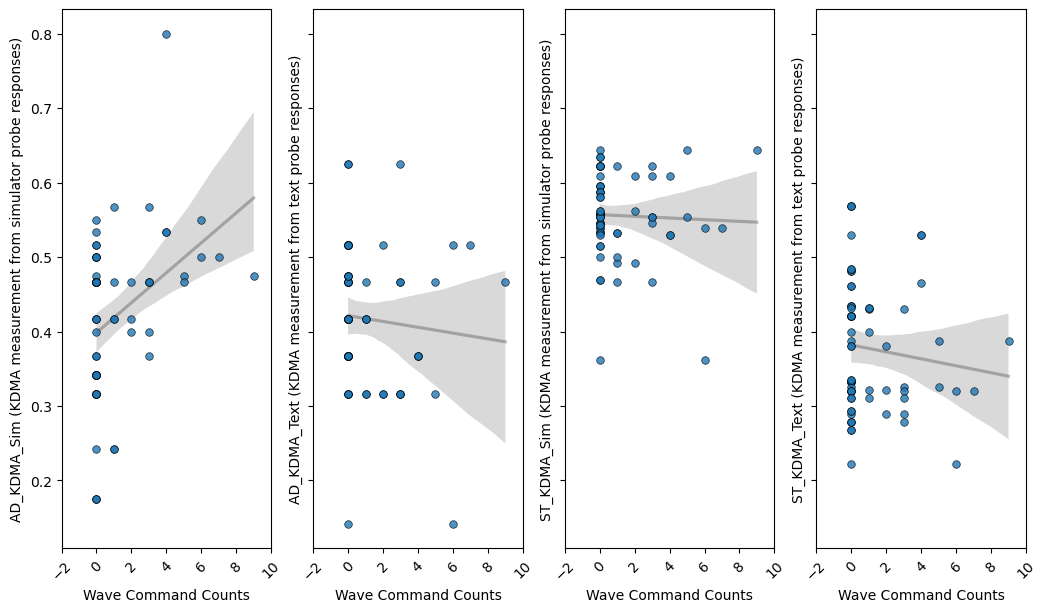

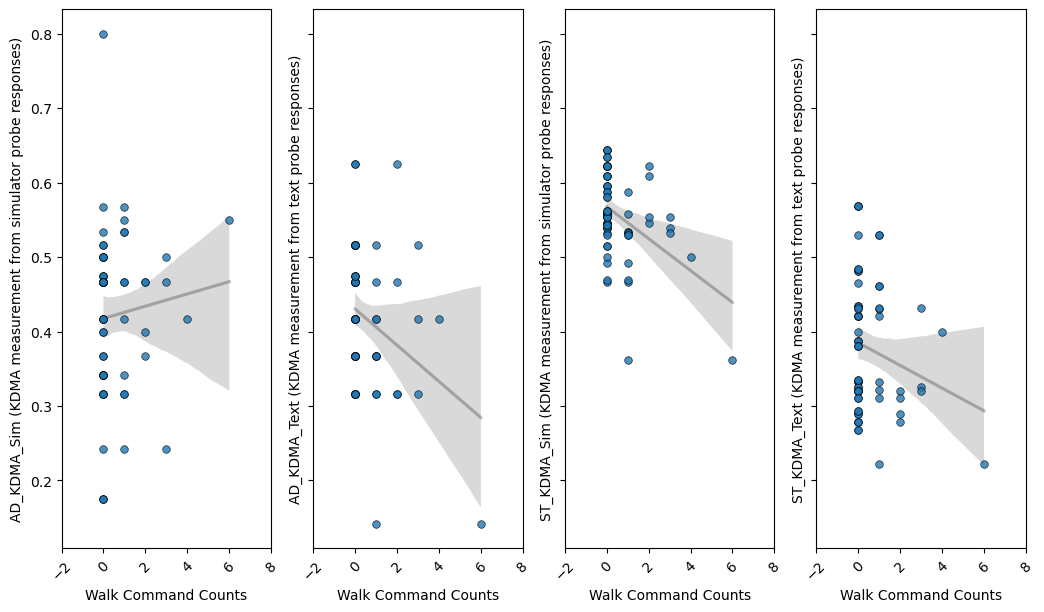

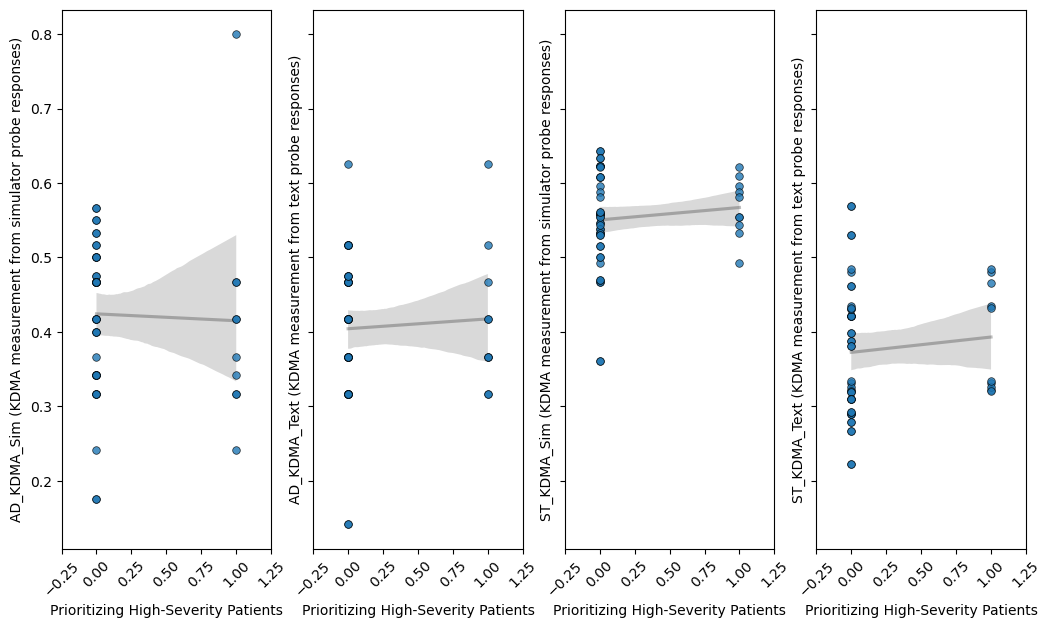

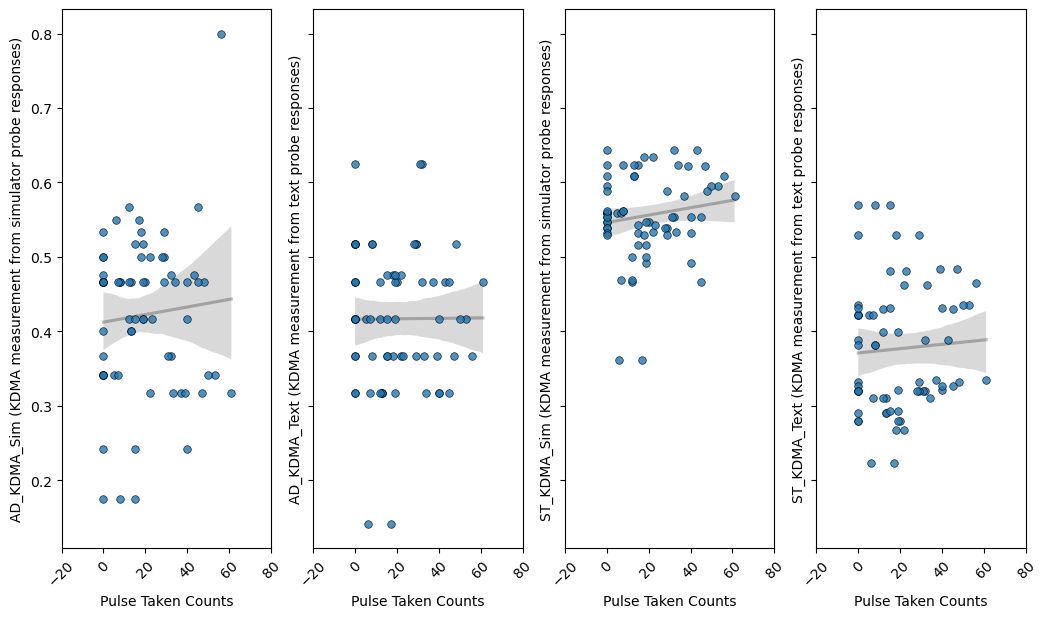

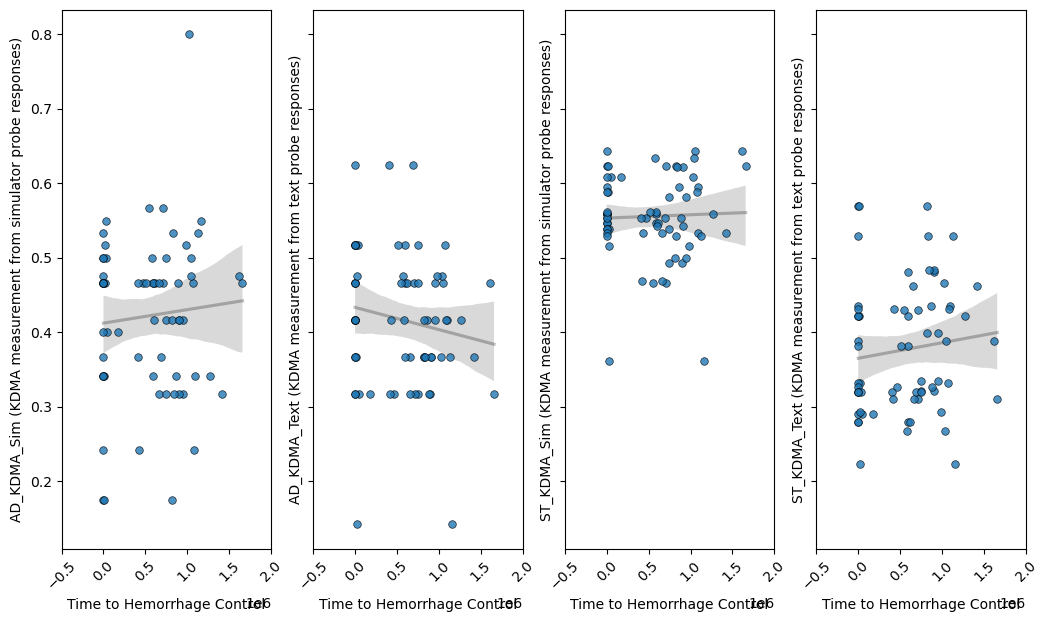

In [18]:

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

kdma_columns = [cn for cn in anova_df.columns if 'KDMA' in cn]
fig_height = 7
line_kws = dict(color='k', zorder=1, alpha=.25)
scatter_kws = dict(s=30, lw=.5, edgecolors='k', zorder=2)
for xname, xlabel in zip(
    [
        'YrsMilExp', 'injury_not_treated_count', 'injury_correctly_treated_count',
        'actual_engagement_distance', 'wave_command_count', 'walk_command_count',
        'prioritize_high_injury_severity_patients', 'pulse_taken_count',
        'time_to_last_hemorrhage_controlled'
    ],
    [
        'Years of Military\nMedical Experience', 'Untreated Injuries', 'Correctly Treated Injuries',
        'Total Distance Travelled\nbetween Engagements', 'Wave Command Counts', 'Walk Command Counts',
        'Prioritizing High-Severity Patients', 'Pulse Taken Counts',
        'Time to Hemorrhage Control'
    ]
):
    
    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(kdma_columns), figsize=(nu.twitter_aspect_ratio*fig_height, fig_height), sharey=True)
    
    for i, yname in enumerate(kdma_columns):
        
        # Create a scatter plot
        merge_axes_subplot = sns.regplot(
            x=xname, y=yname, scatter=True, data=anova_df, ax=axes[i], scatter_kws=scatter_kws, line_kws=line_kws
        )
        
        # Label the x- and y-axis
        axes[i].set_xlabel(xlabel)
        original_column = yname.replace('mean_', '')
        column_description = value_description_dict[original_column]
        axes[i].set_ylabel(f'{original_column} ({column_description})')
        
        # Rotate xtick labels for each subplot (minor adjustment)
        axes[i].set_xticks(axes[i].get_xticks())  # Get current xticks
        plt.setp(axes[i].get_xticklabels(), rotation=45)  # Rotate labels for current axis
    
    plt.show()

In [19]:

import matplotlib.colors as colors
import numpy as np

def plot_correlation_graph(correlations, title_str="Correlation Matrix of ??"):
    
    # Plotting the correlation matrix using matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed
    cmap = plt.get_cmap("coolwarm")
    norm = colors.Normalize(vmin=-1, vmax=1)

    # Create the heatmap
    cax = ax.matshow(correlations, cmap=cmap, norm=norm)

    # Add a color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(correlations.columns)))
    ax.set_yticks(np.arange(len(correlations.columns)))
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    # Add text annotations.
    for (i, j), val in np.ndenumerate(correlations):
        ax.text(j, i, f"{val:.3f}", ha="center", va="center", color="black")
    plt.title(title_str)
    plt.show()

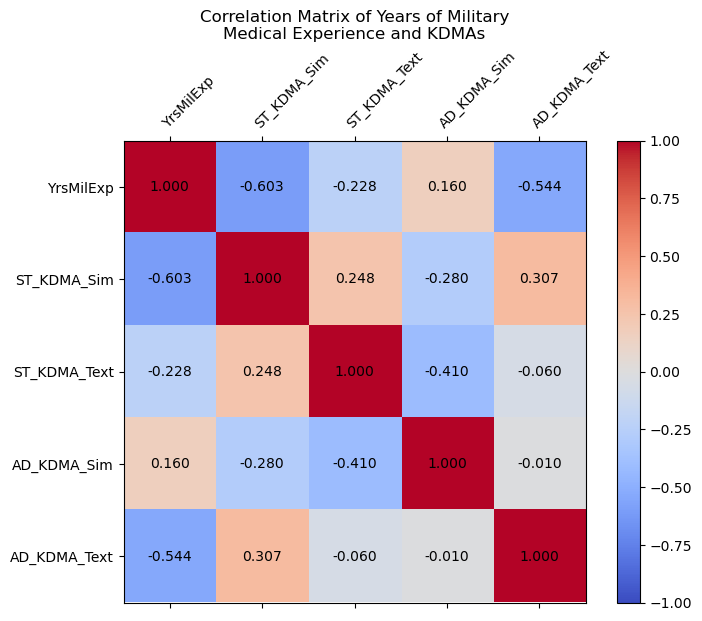

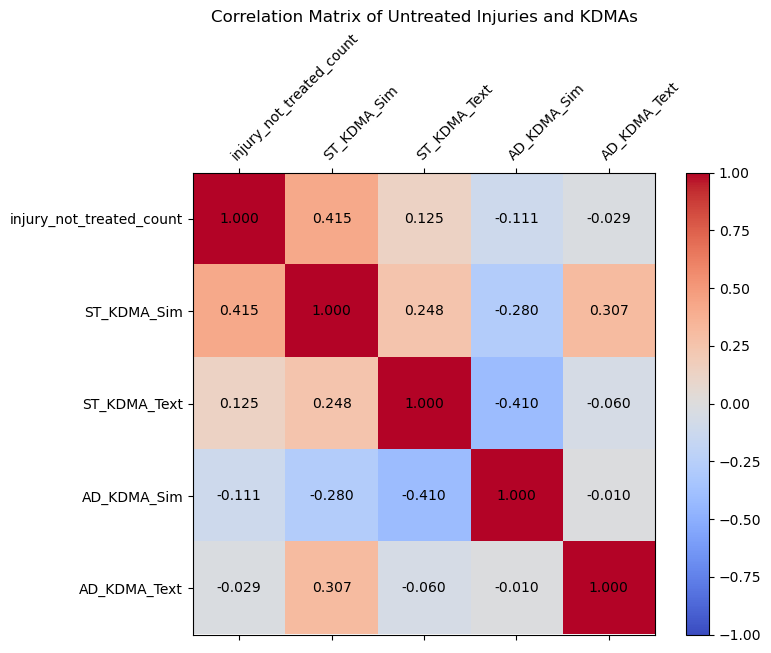

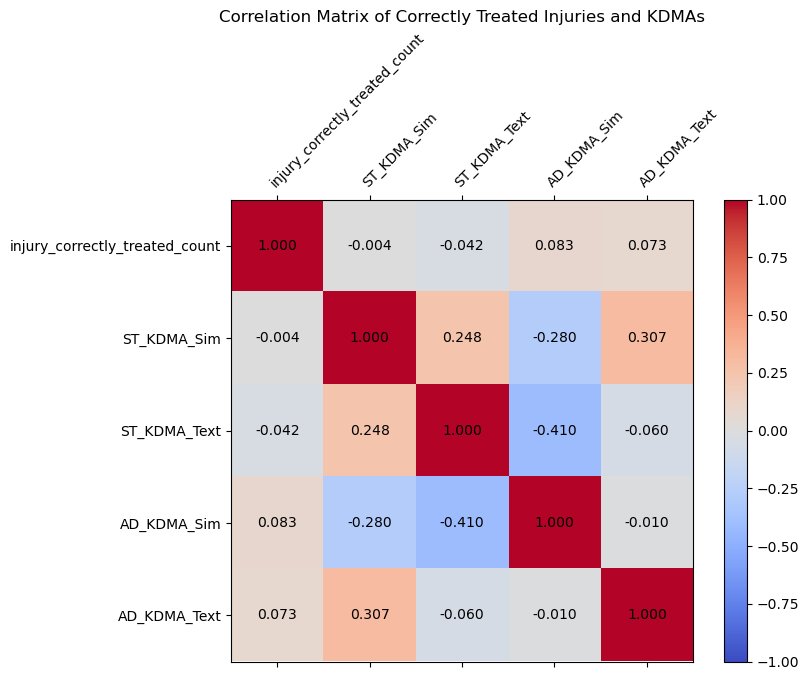

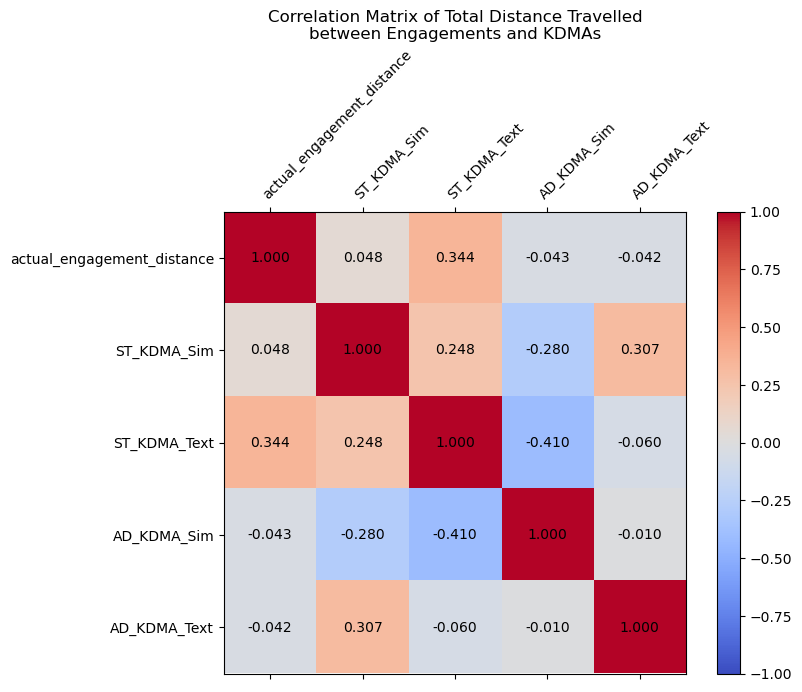

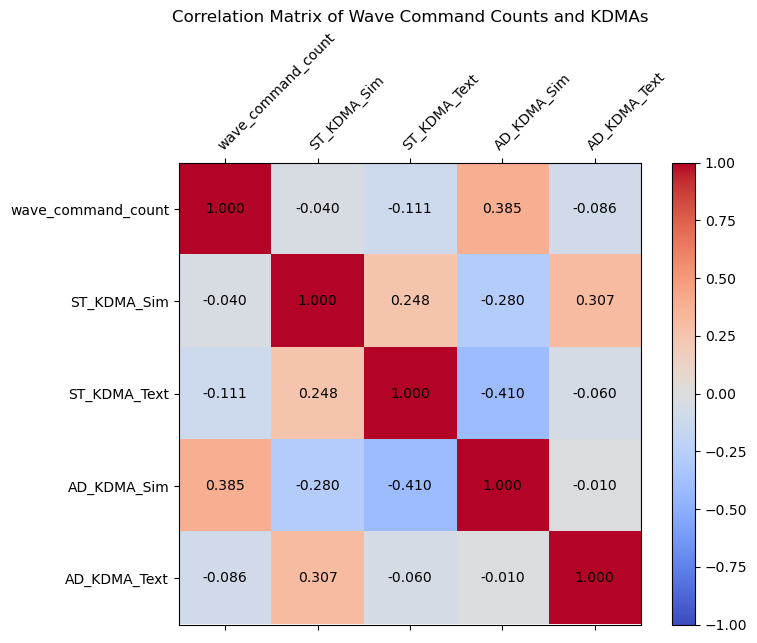

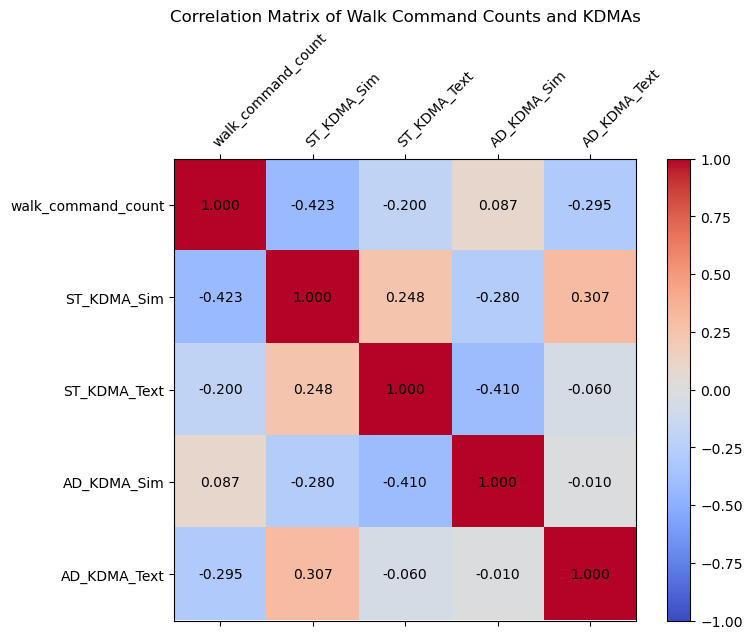

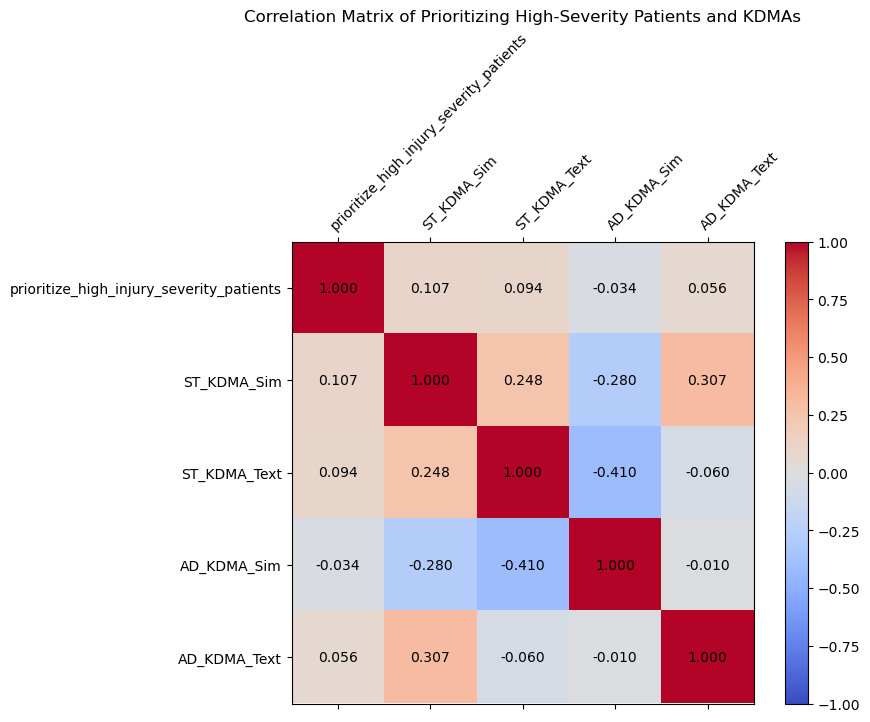

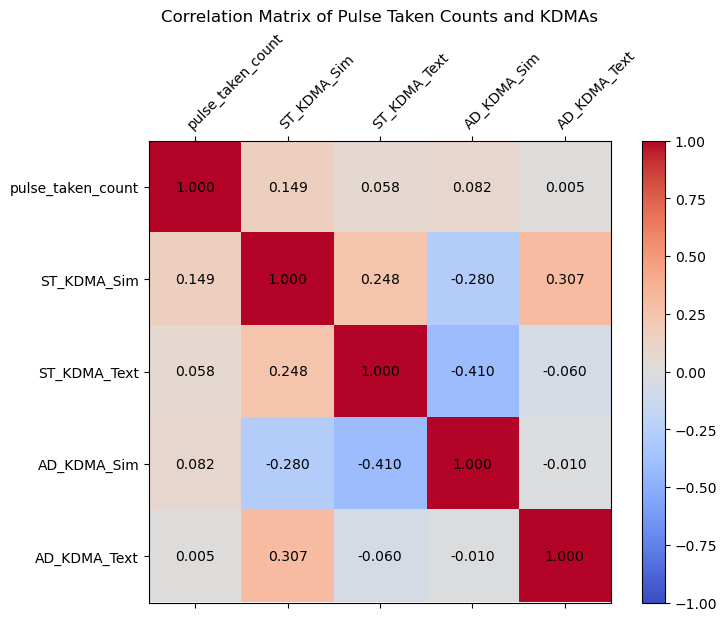

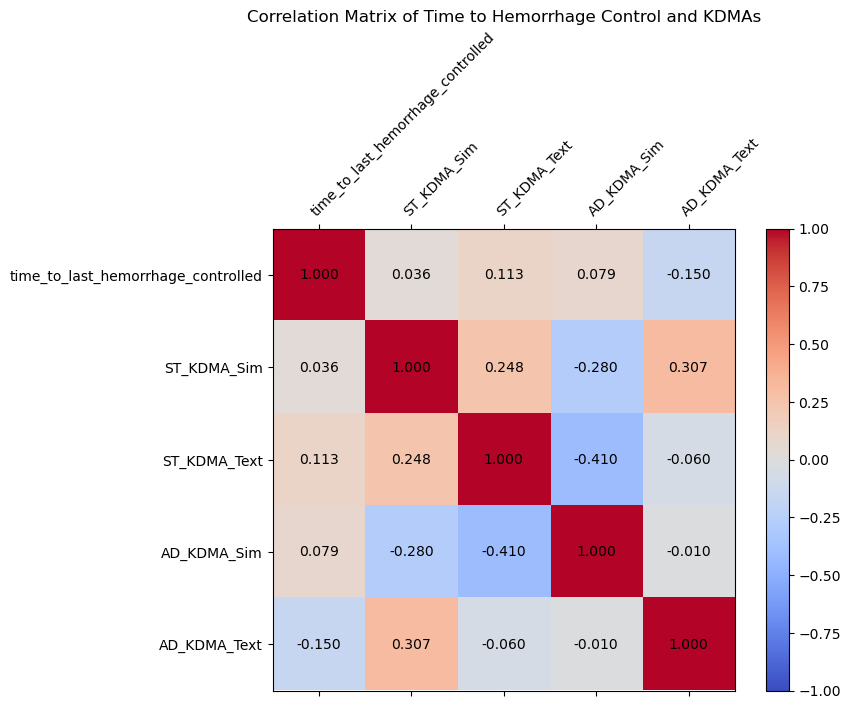

In [21]:

kdma_columns = ['ST_KDMA_Sim', 'ST_KDMA_Text', 'AD_KDMA_Sim', 'AD_KDMA_Text']
for xname, xlabel in zip(
    [
        'YrsMilExp', 'injury_not_treated_count', 'injury_correctly_treated_count',
        'actual_engagement_distance', 'wave_command_count', 'walk_command_count',
        'prioritize_high_injury_severity_patients', 'pulse_taken_count',
        'time_to_last_hemorrhage_controlled'
    ],
    [
        'Years of Military\nMedical Experience', 'Untreated Injuries', 'Correctly Treated Injuries',
        'Total Distance Travelled\nbetween Engagements', 'Wave Command Counts', 'Walk Command Counts',
        'Prioritizing High-Severity Patients', 'Pulse Taken Counts',
        'Time to Hemorrhage Control'
    ]
):
    columns_list = [xname] + kdma_columns
    df = anova_df[columns_list]
    correlations = df.corr().round(3)
    plot_correlation_graph(correlations, title_str=f"Correlation Matrix of {xlabel} and KDMAs")

In [33]:

# Calculate Pearson correlation coefficient between YrsMilExp and each KDMA column
print()
corr_columns = ['mean_AD_KDMA_Sim', 'mean_AD_KDMA_Text', 'mean_PropTrust', 'mean_ST_KDMA_Sim', 'mean_ST_KDMA_Text']
comp_columns = sorted(set(anova_df.columns).difference(set(
    corr_columns + ['participant_id', 'session_uuid', 'scene_id', 'medical_role', 'encounter_layout'] + [cn for cn in anova_df.columns if cn.endswith('_metadata')]
)))
rows_list = []
for corr_name in corr_columns:
    for comp_name in comp_columns:
        correlation = anova_df[comp_name].corr(anova_df[corr_name])
        row_dict = {'corr_name': corr_name, 'comp_name': comp_name, 'correlation': correlation}
        rows_list.append(row_dict)
df = DataFrame(rows_list)


mask_series = (df.corr_name == 'mean_PropTrust')
df[mask_series].sort_values('correlation', ascending=False).head(5)

,corr_name,comp_name,correlation
72,mean_PropTrust,mean_voice_capture_count,0.225009
70,mean_PropTrust,mean_total_actions_count,0.214038
71,mean_PropTrust,mean_triage_time,0.114721
52,mean_PropTrust,mean_YrsMilExp,0.102275
75,mean_PropTrust,mean_walkers_value,0.088642


In [34]:

reason_strs_list = [
    'the order in which still patients are engaged', 'the count of injuries not treated', 'the total distance traveled between patient engagements',
    'the count of injuries correcly treated', 'the number of wave commands (commands to "wave if you can hear me") issued',
    'the number of walk commands issued (commands to "walk to the safe space if you can")', 'years of military medical experience'
]
for reason_str in [
    'different medical roles (e.g., Nurse, EMT)'
]:
    print(
        f"""
I have come up with a guiding question/hypothesis: The KDMA (Key Decision Maker Attribute) values are influencing {reason_str} in a VR simulation of a triage.

KDMAs are Decision Maker Attribute Characteristics of decision-makers indicative of their outcome preferences and/or their decision-making process."""
        """ Examples include risk-seeking vs. risk-aversion, maximizing vs. satisficing, ingroup/outgroup fairness, black tagging (the propensity to"""
        """ move on from a patient expected to die before help comes), stay vs search (the propensity to find all patients before engaging the patients"""
        """ at hand), moral desert (the tendency to not help perpetrators of a bombing, say), personal security risk (the willingness to stay in the"""
        """ line of fire to help someone), protocol/process focus (the tendency to ignore guidelines to help the injured).
    
What questions (that the data may be able to answer) would be natural to ask?"""
)


I have come up with a guiding question/hypothesis: The KDMA (Key Decision Maker Attribute) values are influencing different medical roles (e.g., Nurse, EMT) in a VR simulation of a triage.

KDMAs are Decision Maker Attribute Characteristics of decision-makers indicative of their outcome preferences and/or their decision-making process. Examples include risk-seeking vs. risk-aversion, maximizing vs. satisficing, ingroup/outgroup fairness, black tagging (the propensity to move on from a patient expected to die before help comes), stay vs search (the propensity to find all patients before engaging the patients at hand), moral desert (the tendency to not help perpetrators of a bombing, say), personal security risk (the willingness to stay in the line of fire to help someone), protocol/process focus (the tendency to ignore guidelines to help the injured).
    
What questions (that the data may be able to answer) would be natural to ask?



Based on the results below, what interpretation might I give on these particular tests to compare the number of walk commands issued (commands to "walk to the safe space if you can") with the KDMA values and what conclusions might I draw:

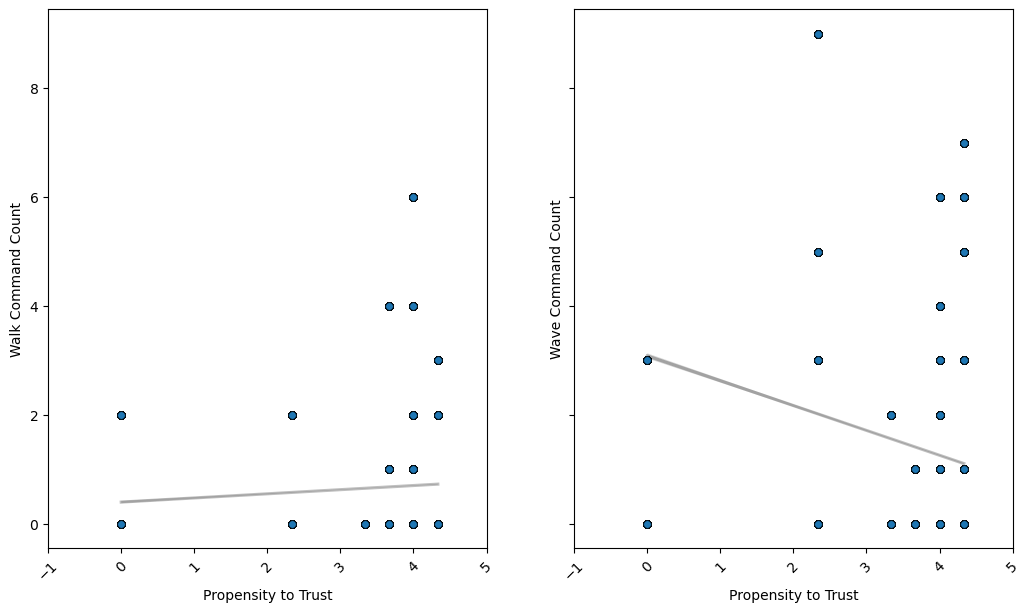

In [60]:

# Create a figure and subplots
command_columns = [cn for cn in anova_df.columns if 'command' in cn]
fig, axes = plt.subplots(nrows=1, ncols=len(command_columns), figsize=(nu.twitter_aspect_ratio*fig_height, fig_height), sharey=True)

line_kws = dict(color='k', zorder=1, alpha=.25)
scatter_kws = dict(s=30, lw=.5, edgecolors='k', zorder=2)
for i, cn in enumerate(command_columns):
    
    # Create a scatter plot
    merge_axes_subplot = sns.regplot(
        x='mean_PropTrust', y=cn, scatter=True, data=anova_df, ax=axes[i], scatter_kws=scatter_kws, line_kws=line_kws
    )
    
    # Label the x- and y-axis
    axes[i].set_xlabel('Propensity to Trust')
    original_column = cn.replace('mean_', '')
    column_description = ' '.join([s.title() for s in original_column.split('_')])
    axes[i].set_ylabel(column_description)
    
    # Rotate xtick labels for each subplot (minor adjustment)
    axes[i].set_xticks(axes[i].get_xticks())  # Get current xticks
    plt.setp(axes[i].get_xticklabels(), rotation=45)  # Rotate labels for current axis

plt.show()

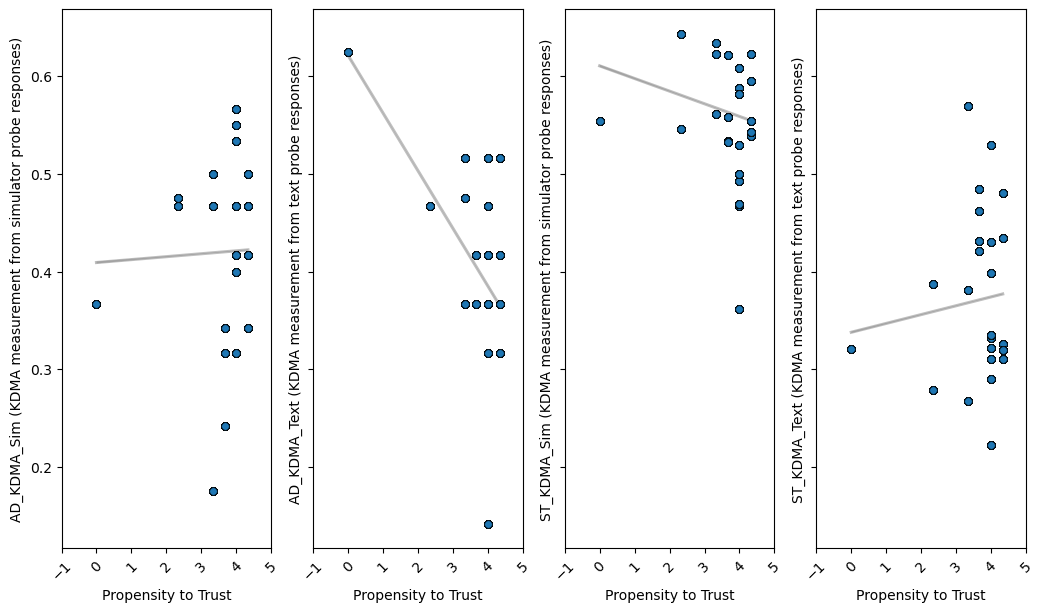

In [62]:

# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=len(kdma_columns), figsize=(nu.twitter_aspect_ratio*fig_height, fig_height), sharey=True)

for i, cn in enumerate(kdma_columns):
    
    # Create a scatter plot
    merge_axes_subplot = sns.regplot(
        x='mean_PropTrust', y=cn, scatter=True, data=anova_df, ax=axes[i], scatter_kws=scatter_kws, line_kws=line_kws
    )
    
    # Label the x- and y-axis
    axes[i].set_xlabel('Propensity to Trust')
    original_column = cn.replace('mean_', '')
    column_description = value_description_dict[original_column]
    axes[i].set_ylabel(f'{original_column} ({column_description})')
    
    # Rotate xtick labels for each subplot (minor adjustment)
    axes[i].set_xticks(axes[i].get_xticks())  # Get current xticks
    plt.setp(axes[i].get_xticklabels(), rotation=45)  # Rotate labels for current axis

plt.show()

In [35]:

# Break up the metadata columns into their own columns
import re

metadata_columns = sorted([cn for cn in anova_df.columns if cn.endswith('_metadata')])
for cn in metadata_columns:
    str_prefix = re.split('_metadata', cn, 0)[0]
    
    # Split the pipe-delimited values into a DataFrame
    split_df = anova_df[cn].str.split('|', expand=True)

    # Change the column names to reflect the content
    split_df.columns = [
        f'{str_prefix}_patient_id', f'{str_prefix}_engagement_start', f'{str_prefix}_location_tuple', f'{str_prefix}_patient_sort',
        f'{str_prefix}_predicted_priority', f'{str_prefix}_injury_severity'
    ]
    
    # Add the split columns to the original DataFrame
    anova_df = concat([anova_df, split_df], axis='columns')
    
    # Drop the original column
    anova_df = anova_df.drop(columns=[cn, f'{str_prefix}_predicted_priority'])

In [36]:

anova_df.columns.tolist()

['participant_id', 'session_uuid', 'scene_id', 'medical_role', 'encounter_layout', 'mean_AD_KDMA_Sim', 'mean_AD_KDMA_Text', 'mean_PropTrust', 'mean_ST_KDMA_Sim', 'mean_ST_KDMA_Text', 'mean_YrsMilExp', 'mean_actual_engagement_distance', 'mean_first_engagement', 'mean_first_treatment', 'mean_injury_correctly_treated_count', 'mean_injury_not_treated_count', 'mean_injury_treatments_count', 'mean_injury_wrongly_treated_count', 'mean_last_engagement', 'mean_last_still_engagement', 'mean_measure_of_right_ordering', 'mean_patient_count', 'mean_percent_hemorrhage_controlled', 'mean_pulse_taken_count', 'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_time_to_last_hemorrhage_controlled', 'mean_total_actions_count', 'mean_triage_time', 'mean_voice_capture_count', 'mean_walk_command_count', 'mean_walk_value', 'mean_walkers_value', 'mean_wave_command_count', 'mean_wave_value', 'engaged_patient00_patient_id', 'engaged_patient00_engagement_start', 'engag

In [ ]:

groupby_columns = ['participant_id', 'session_uuid', 'scene_id']
for (participant_id, session_uuid, scene_id), scene_df in anova_df.groupby(groupby_columns):
    df = scene_df.dropna(axis='columns', how='all')
    print(df.shape)

In [37]:

injury_severity_columns = [cn for cn in anova_df.columns if cn.endswith('_injury_severity')]
injury_severity_columns

['engaged_patient00_injury_severity', 'engaged_patient01_injury_severity', 'engaged_patient02_injury_severity', 'engaged_patient03_injury_severity', 'engaged_patient04_injury_severity', 'engaged_patient05_injury_severity', 'engaged_patient06_injury_severity', 'engaged_patient07_injury_severity', 'engaged_patient08_injury_severity', 'engaged_patient09_injury_severity', 'engaged_patient10_injury_severity', 'engaged_patient11_injury_severity', 'unengaged_patient00_injury_severity', 'unengaged_patient01_injury_severity', 'unengaged_patient02_injury_severity', 'unengaged_patient03_injury_severity', 'unengaged_patient04_injury_severity', 'unengaged_patient05_injury_severity', 'unengaged_patient06_injury_severity', 'unengaged_patient07_injury_severity', 'unengaged_patient08_injury_severity', 'unengaged_patient09_injury_severity', 'unengaged_patient10_injury_severity', 'unengaged_patient11_injury_severity', 'unengaged_patient12_injury_severity', 'unengaged_patient13_injury_severity']

In [56]:

description_str = 
assert description_str == '0=Highest severity patient not engaged first, 1=Highest severity patient engaged first', f"description_str = '{description_str}'"

In [53]:

print(anova_df.groupby('prioritize_high_injury_severity_patients').size().to_frame().rename(columns={0: 'record_count'}))

                                          record_count
prioritize_high_injury_severity_patients              
0.0                                             160139
1.0                                              39252



## Overall Considerations

While KDMAs might influence triage decisions, it's important to remember the role of triage protocols and guidelines. These protocols might override KDMA influences and dictate specific actions for different patient presentations.

Further analysis with your actual data can provide more concrete insights into the relationships between KDMAs, triage decision-making, experience, and medical roles.